# Notebook to generate RAS maps - pinkbombs
## PROVISIONAL

General imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement

In [4]:
import zipfile 
import os 

In [5]:
import fiona 
import geopandas as gpd 
from bs4 import BeautifulSoup 

In [6]:
import requests

## 1 - Inputs

### 1.1 - RAS dataset adapted from Esther (Google Sheet)
Here we use the dataset put together by Esther and modified/expanded by Antoine/Sarah/Paul (see link to Google Drive below)

https://docs.google.com/spreadsheets/d/1vtZzw8y8IrfWjK2ItR33ApJ0ww10r7_n/edit?usp=sharing&ouid=113313479374754815448&rtpof=true&sd=true

In [281]:
# Load adapted dataset - download from Google sheet
ras_file = "data_ras/Projets RAS Locations.xlsx - RAS.csv" 
projets_ras = pd.read_csv(ras_file) #, encoding='unicode_escape')

In [282]:
projets_ras.columns.values
projets_ras.shape

(140, 26)

In [283]:
projets_ras.head(3)

,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Link info (no text),Technologie,Etat d'avancement,...,Latest update,Country,Location,Matching Location,Comment on location,Location source,Latitude,Longitude,Errors found,Exclude
0,Andfjord Salmon (Kvalnes),Andfjord Salmon,NaN,"39,000",NaN,non,passage à la phase 2 càd de 1000 à 19000 tonn...,NaN,FTS,En fonctionnement,...,NaN,Norway,"Kvalnes, Andøya",Kvalnes,NaN,NaN,69.158148,16.093888,C'est du FTS (Flow Through Systems) et pas RAS,NaN
1,Atlantic Sapphire,Atlantic Sapphire,"1,000","200,000",NaN,oui,https://www.fishfarmingexpert.com/atlantic-sap...,https://www.seafoodsource.com/news/aquaculture...,RAS,En fonctionnement,...,2023.0,United States,"Homstead, Florida",NaN,"Homstead, Miami-Dade County, Florida",https://www.fishfarmingexpert.com/atlantic-sap...,25.468759,-80.481078,"Correct production from 9,500 to 200,000 based...",NaN
2,Quality Salmon,Quality Salmon,NaN,"100,000",NaN,non,https://www.seafoodsource.com/news/aquaculture...,https://www.intrafish.com/salmon/most-definite...,RAS,Conceptuel,...,2023.0,Sweden,"Sotenäs, Kungshamn",Kungshamn,NaN,https://www.seafoodsource.com/news/aquaculture...,NaN,NaN,NaN,NaN


### 1.2 - Carbon emissions by country for Data enrichment  
To represent the carbon footprint on the map, we bring a publicaly available dataset on Carbon intensity by country

https://ourworldindata.org/grapher/carbon-intensity-electricity?tab=table

In [284]:
# Load data for Carbon intensity of electricity generation by country
carbon_file = "data_ras/carbon-intensity-electricity.csv" 
carbon_elec = pd.read_csv(carbon_file) 

In [285]:
# For each country, take most recent data point (2022, if not 2021,...)
carbon_elec22 = carbon_elec.loc[carbon_elec.groupby('Entity').Year.idxmax()]
#carbon_elec22 = carbon_elec.loc[carbon_elec['Year'] == 2022,]
carbon_elec22.head(10)

,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh
22,ASEAN (Ember),NaN,2022,508.204220
44,Afghanistan,AFG,2021,120.481926
66,Africa,NaN,2021,484.696530
88,Africa (Ember),NaN,2021,484.696470
110,Albania,ALB,2021,23.437498
132,Algeria,DZA,2021,485.489500
154,American Samoa,ASM,2021,687.500000
176,Angola,AGO,2021,195.982960
198,Antigua and Barbuda,ATG,2021,657.142900
221,Argentina,ARG,2022,344.306800


In [286]:
# Show the key countries of interest
#carbon_elec22.sort_values('Carbon intensity of electricity - gCO2/kWh', ascending=False).head(10)
carbon_elec22.loc[carbon_elec22.Entity.isin(['Norway', 'United States', 'France', 
                                             'Portugal', 'China', 'United Kingdom', 
                                             'Iceland', 'Saudi Arabia']), ].sort_values('Carbon intensity of electricity - gCO2/kWh', 
                                                                                        ascending=False)

,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh
4114,Saudi Arabia,SAU,2022,557.782800
982,China,CHN,2022,533.982800
4911,United States,USA,2022,368.101960
4888,United Kingdom,GBR,2022,261.154900
3834,Portugal,PRT,2022,234.604720
1696,France,FRA,2022,84.879000
3541,Norway,NOR,2022,28.924809
2210,Iceland,ISL,2021,28.556593


In [287]:
## Merge with RAS dataset
projets_ras = projets_ras.merge(carbon_elec22, left_on='Country', right_on='Entity', how='left')
#projets_ras.head()

### 1.3 - Conversion parameters
We also need conversion parameters for the farms production. The figure for electricity consumption per kg of salmon produced is from a peer-reviewed publication

https://www.sciencedirect.com/science/article/pii/S0144860923000171

In [288]:
# Electricity consumption per kg of salmon produced
elec_per_kg = 9.59 #kWh/kg == 9.59 * 1000 / tonne

In [289]:
# Convert Production to integer
projets_ras['Production Max'] = projets_ras['Production Max'].apply(lambda x: np.nan if pd.isna(x) else int(x.replace(',','')))

# Calculate Electricity consumption for each farm 
projets_ras['elec_conso_kWh'] = projets_ras['Production Max']*elec_per_kg*1000

In [290]:
# Calculate CO2 emissions for each farm from Electricity consumption of country for each farm
# convert g CO2 into kilotons CO2 (divide by 1e9)
projets_ras['carbon_elec_kt'] = projets_ras['elec_conso_kWh'] * projets_ras['Carbon intensity of electricity - gCO2/kWh']/1e9

The conversion factors between production and C02 emissions are no longer used as it will vary from country to country
- 10 FULL SUPPLY CHAIN inc. transport - WWF - https://www.worldwildlife.org/publications/measuring-and-mitigating-ghgs-salmon
- 5.77 - Agribalyse - https://agribalyse.ademe.fr/app/aliments/26036#Saumon,_cru,_élevage
- 57 - Land-based - Compassion in Animal Farming - CIWF, International Salmon Farmers Association (2015) The evolution of land based Atlantic salmon farms

In [291]:
### NOT USED ####
# Carbon footprint of farmed salmon
#carbon_per_kg = 57 #kg C02 equ / kg LW == 57t C02 / t LW 
# Calculate CO2 emissions directly from production for each farm -- NOT USED
#projets_ras['carbon_footprint_t'] = projets_ras['Production Max']*carbon_per_kg

### 1.4 - Data Filtering - SCOPE
Here we implement the agreed scope for the map:
- Technology: RAS and Hybrid, excluding FTS and SIFT
- Species: Salmon species, so excluding Yellowtail, Shrimp, Trout, Kingfish, Steelhead trout, Rainbow trout
- Etat d'avancement: All status except those abandonned - but keep 'Stopped' (ie. constructed but then stopped).
- Exclude: farm marked as exclude because duplicated or other reason

In [292]:
# For farms with no entry in Species, set to 'Atlantic Salmon'
projets_ras['Species'] = np.where(projets_ras['Species'].isna(), 'Atlantic Salmon', projets_ras['Species'])

In [296]:
# Define criteria lists
techno_no = ['FTS', 'SIFT']
species_no = ['Yellow tail', 'Shrimp', 'Smolt', 'Patagonia King Salmon smolt', 'Steelhead', 
              'Rainbow trout', 'Barramundi and Himalayan Rainbow Trout', 'Trout', 'Kingfish tail']
etat_no = ['Abandon']

In [298]:
#projets_ras["Species"].value_counts()
#projets_ras["Technologie"].value_counts()
#projets_ras["Exclude"].value_counts()

In [299]:
# Summary of what we exclude and why
excluded = {'Exclude_yes': sum(projets_ras['Exclude'] == 'yes'),
            'Techno': sum(projets_ras['Technologie'].isin(techno_no)),
            'Species': sum(projets_ras['Species'].isin(species_no)),
            'Etat': sum(projets_ras["Etat d'avancement"].isin(etat_no))}
excluded

{'Exclude_yes': 13, 'Techno': 8, 'Species': 13, 'Etat': 7}

In [300]:
projets_ras = projets_ras.loc[(projets_ras['Exclude'] != 'yes') & 
            (~projets_ras['Technologie'].isin(techno_no)) &
            (~projets_ras['Species'].isin(species_no)) & 
            (~projets_ras["Etat d'avancement"].isin(etat_no)),]

In [301]:
projets_ras.shape

(111, 32)

In [303]:
projets_ras["Species"].value_counts() ## To change in spreadsheet!!! 

Species
Atlantic Salmon                  105
King Salmon                        2
Atlantic Salmon (Salmo Salar)      1
Salmon                             1
Coho                               1
Sockeye                            1
Name: count, dtype: int64

## 2 - Exploratory Data Analysis

### 2.1 - Status

In [304]:
# Map fields into english
projets_ras['Detailed status'] = projets_ras["Etat d'avancement"].map({'En construction': 'In construction', 
                                                                       'En fonctionnement': 'Operating',
                                                                       'Arrêt': 'Stopped',
                                                                       'Blocage Opposition': 'Local opposition',
                                                                       'Blocage financier': 'Financial block',
                                                                       'Bloquage législatif': 'Legal block',
                                                                       'Conceptuel': 'Conceptual',
                                                                       'Permis': 'Permit'})

In [305]:
#projets_ras.groupby(["Detailed status", "Etat d'avancement"]).size()

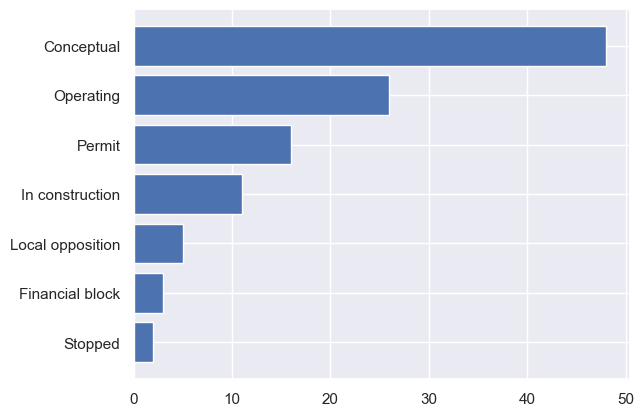

In [306]:
# Histogram of stages
df = projets_ras['Detailed status'].value_counts().reset_index().sort_values(by=['count'])
plt.barh(y=df['Detailed status'], width=df['count'])
plt.show()

In [307]:
# Categorise Detailed status into 3 status in english
concept = ['Local opposition', 'Financial block', 'Legal block', 'Conceptual', 'Permit']
projets_ras['Status'] = np.where(projets_ras['Detailed status'].isin(concept), 'Project', projets_ras['Detailed status'])
projets_ras.groupby(["Status", 'Detailed status']).size()

Status           Detailed status 
In construction  In construction     11
Operating        Operating           26
Project          Conceptual          48
                 Financial block      3
                 Local opposition     5
                 Permit              16
Stopped          Stopped              2
dtype: int64

In [308]:
# Aggregate the table by countries and detailed status
ras_country = projets_ras.groupby(["Country", "Detailed status"]).size().reset_index()
ras_country.columns = ["Country", "Detailed status", "count"]
ras_country = ras_country.pivot_table(values='count', index=['Country'], columns=["Detailed status"], aggfunc="sum").fillna(0).reset_index()

In [309]:
# Caluclate total number of farms for each country
col_sum = ['Stopped', 'In construction', 'Operating','Local opposition', 'Financial block', 'Conceptual', 'Permit']
ras_country['tot_ras_farms'] = ras_country[col_sum].sum(axis=1)
ras_country.sort_values('tot_ras_farms', ascending=False).head()

Detailed status,Country,Conceptual,Financial block,In construction,Local opposition,Operating,Permit,Stopped,tot_ras_farms
13,Norway,13.0,2.0,5.0,0.0,2.0,13.0,0.0,35.0
26,United States,3.0,1.0,1.0,2.0,4.0,0.0,0.0,11.0
4,China,3.0,0.0,0.0,0.0,4.0,0.0,0.0,7.0
9,Japan,2.0,0.0,1.0,0.0,2.0,0.0,0.0,5.0
25,United Kingdom,2.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0


### 2.1 - Energy Consumption

Text(0, 0.5, 'Number of farms')

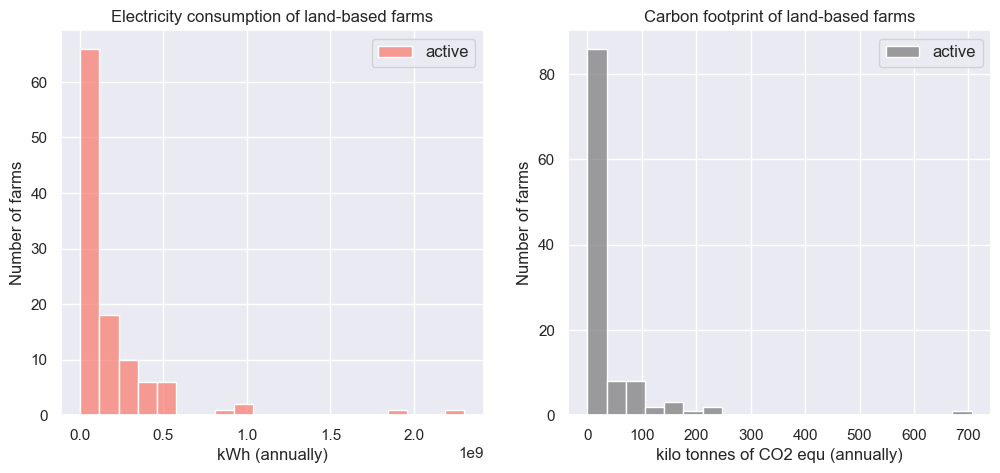

In [310]:
# Histogram of Elec conso & Carbon footprint
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.set(style="darkgrid")
sns.histplot(projets_ras['elec_conso_kWh'], label='active', bins=20, color="salmon", ax = axs[0])
axs[0].legend(prop={'size': 12})
axs[0].set_title('Electricity consumption of land-based farms')
axs[0].set_xlabel('kWh (annually)')
axs[0].set_ylabel('Number of farms')

sns.histplot(projets_ras['carbon_elec_kt'], label='active', bins=20, color="gray", ax = axs[1])
axs[1].legend(prop={'size': 12})
axs[1].set_title('Carbon footprint of land-based farms')
axs[1].set_xlabel('kilo tonnes of CO2 equ (annually)')
axs[1].set_ylabel('Number of farms')

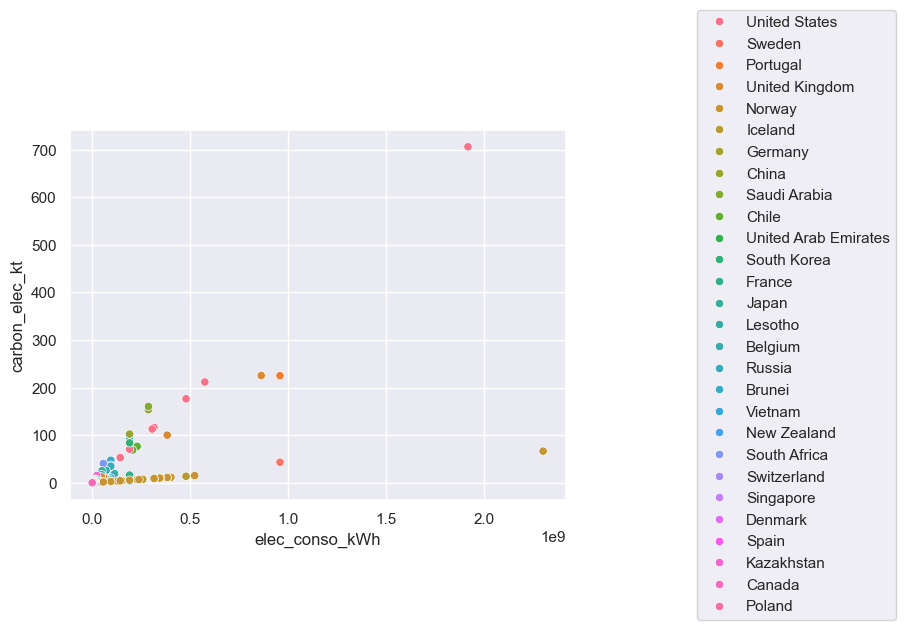

In [311]:
## Plot Carbon footprint vs. elec production
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.scatterplot(data=projets_ras, x='elec_conso_kWh', y='carbon_elec_kt', hue='Country', ax = axs)
axs.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

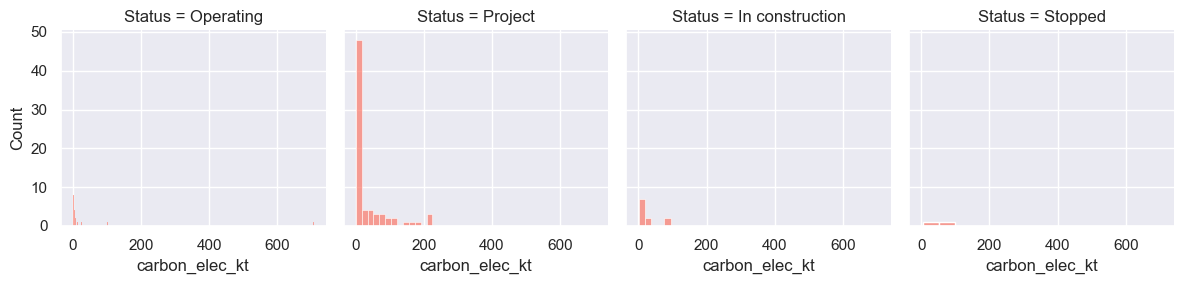

In [312]:
g = sns.FacetGrid(projets_ras, col="Status")
g.map(sns.histplot, 'carbon_elec_kt', color="salmon")

### 3 - Transform dataset into geopandas with Lat/Long Coordinates
The manual data collection involves finding the village/town of the farm, which can be associated with coordinates (Latitude, Longitude) automatically using the opendatasoft database for town > 1000 inhabitants (link below). For the farms in smaller village or if the town has a too common name, the coordinates were entered manually using Google maps. As a result, in this section, we bring the coordinates for part of the dataset, create geopandas datasets and join them back together.

https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/json?lang=en&timezone=Europe%2FBerlin

In [313]:
# Load coordinates dataset 
cities = gpd.read_file('data_ras/geonames-all-cities-with-a-population-1000.geojson')
#cities.head()

In [314]:
#cities.cou_name_en.value_counts().reset_index().head(50)

In [315]:
# New column for country names to match geo dataset
projets_ras['CountryG'] = projets_ras['Country']
projets_ras.loc[projets_ras['CountryG'] == 'Russia', 'CountryG'] = 'Russian Federation'
projets_ras.loc[projets_ras['CountryG'] == 'Vietnam', 'CountryG'] = 'Viet Nam'
projets_ras.loc[projets_ras['CountryG'] == 'Brunei', 'CountryG'] = 'Brunei Darussalam'

### 3.1 - Part 1
Farms with existing Lat/Long coordinates in the input file

In [316]:
# PART 1 - Farms with LatLong coord
projets_ras_co1 = projets_ras.loc[projets_ras['Latitude'].isna() == False,]
projets_ras_co1.shape

(64, 35)

In [317]:
# Create geopandas
projets_ras_co1_gpd = gpd.GeoDataFrame(projets_ras_co1,
                                 geometry=gpd.points_from_xy(projets_ras_co1['Longitude'], projets_ras_co1['Latitude']), 
                                 crs="EPSG:4326")
projets_ras_co1_gpd.head(3)
#projets_ras_co1_gpd.shape

,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Link info (no text),Technologie,Etat d'avancement,...,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh,elec_conso_kWh,carbon_elec_kt,Detailed status,Status,CountryG,geometry
1,Atlantic Sapphire,Atlantic Sapphire,"1,000",200000.0,NaN,oui,https://www.fishfarmingexpert.com/atlantic-sap...,https://www.seafoodsource.com/news/aquaculture...,RAS,En fonctionnement,...,United States,USA,2022,368.101960,1.918000e+09,706.019559,Operating,Operating,United States,POINT (-80.48108 25.46876)
5,Norwegian Mountain Salmon,Norwegian Mountain Salmon,NaN,90000.0,NaN,NaN,https://thefishsite.com/articles/is-lewis-set-...,https://thefishsite.com/articles/is-lewis-set-...,Hybrid FTS/RAS,Conceptuel,...,United Kingdom,GBR,2022,261.154900,8.631000e+08,225.402794,Conceptual,Project,United Kingdom,POINT (-7.10202 58.10483)
9,Ardal Aqua,Ardal Aqua,NaN,3000.0,15000.0,non,https://www.seafoodsource.com/news/aquacultur...,NaN,RAS,En construction,...,Norway,NOR,2022,28.924809,2.877000e+07,0.832167,In construction,In construction,Norway,POINT (6.16721 59.15153)


In [318]:
#sum(projets_ras_co1_gpd['geometry'].isna())

### 3.2 - Part 2
Farms where we need to match the location. We only use regular matching here against the Matching location and country. No fuzzy matching is implemented.

In [319]:
# Check data issues
projets_ras.loc[(projets_ras['Location'].isna()) & (projets_ras['Latitude'].isna()),
['Company', 'Parent company', 'Technologie', "Etat d'avancement", 'Location','Matching Location', 'Latitude','Errors found','Exclude']]

,Company,Parent company,Technologie,Etat d'avancement,Location,Matching Location,Latitude,Errors found,Exclude
45,Pure Salmon Chine,Pure Salmon,NaN,Conceptuel,NaN,NaN,NaN,NaN,NaN
48,Salmon Evolution,Salmon Evolution,NaN,En construction,NaN,NaN,NaN,duplicate,maybe
62,Leroy Arskog,Leroy Arskog,RAS,Conceptuel,NaN,NaN,NaN,Pour moi c'est la même centrale que celle de K...,maybe


In [320]:
# Part 2 - Farms with no coordinates but locations  --> simple matching
projets_ras_loc = projets_ras.loc[(projets_ras['Location'].isna() == False) & (projets_ras['Latitude'].isna()),]

In [321]:
# Merge geometry to original dataset
#projets_ras_locxy = projets_ras_loc.merge(cities_sub[['name', 'geometry']], left_on='Location', right_on='name', how='left')
#type(projets_ras_locxy)

In [322]:
# Match on location AND country
projets_ras_locxyB = projets_ras_loc.merge(cities[['name', 'cou_name_en', 'geometry']], how='left',
                                           left_on=['Matching Location', 'CountryG'], 
                                           right_on=['name', 'cou_name_en'])

In [323]:
# How many not found?
sum(projets_ras_locxyB['name'].isna())

2

In [324]:
## Show those not found through matching
projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna(),['Company', 'Country', 'CountryG', 'Location', 'Matching Location', 
                                                          'Comment on location', 'name', 'geometry']]

,Company,Country,CountryG,Location,Matching Location,Comment on location,name,geometry
9,Eco Seafood,Norway,Norway,Træna ?,NaN,NaN,NaN,None
33,Smogenlax,Norway,Norway,Kungshamn,Kungshamn,Kungshamn,NaN,None


In [325]:
# Set dataframe for part 2 dropping the 2 columns not in part 1
projets_ras_co2 = projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna() == False,].drop(columns=['name', 'cou_name_en'])

In [326]:
#projets_ras_co2.columns.values
projets_ras_co2.shape

(44, 36)

In [355]:
# Put into GeoDataFrame
projets_ras_co2_gpd = gpd.GeoDataFrame(projets_ras_co2)
#projets_ras_co2_gpd.head()

### 3.3 - Combine Part 1 and 2 and checks
Here we combine the 2 geodataframes together and check that all the farms in scope (Section 2) have the fields required for mapping (Lat/Long) and for display on the pop-up windows. 

In [356]:
# Combine Part 1 and Part 2
projets_ras_co_gpd = pd.concat([projets_ras_co1_gpd, projets_ras_co2_gpd]).reset_index()

In [357]:
projets_ras_co_gpd.tail(3)

,index,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Link info (no text),Technologie,...,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh,elec_conso_kWh,carbon_elec_kt,Detailed status,Status,CountryG,geometry
105,43,Blue Horizon Coho,Blue Horizon Coho,NaN,500.0,NaN,oui,https://www.hishingsmart.com/projects/dongyin...,NaN,NaN,...,China,CHN,2022,533.98280,4795000.0,2.560448,Operating,Operating,China,POINT (118.49165 37.46271)
106,44,BDV /SAS,BDV /SAS,NaN,100.0,NaN,oui,https://www.pdm-seafoodmag.com/lactualite/saum...,NaN,RAS,...,France,FRA,2022,84.87900,959000.0,0.081399,Operating,Operating,France,POINT (-1.10384 49.31604)
107,45,West Creek Aquaculture,West Creek Aquaculture,NaN,90.0,NaN,NaN,https://www.salmonbusiness.com/these-are-the-l...,NaN,NaN,...,Canada,CAN,2022,125.84192,863100.0,0.108614,Operating,Operating,Canada,POINT (-121.76926 49.23298)


In [358]:
projets_ras_co_gpd.shape

(108, 37)

In [359]:
# To save dataset as csv and construct map elsewhere, we save the lat/long or y/x for all
projets_ras_co_gpd['Lat'] = projets_ras_co_gpd['geometry'].y
projets_ras_co_gpd['Long'] = projets_ras_co_gpd['geometry'].x

In [360]:
#projets_ras_co_gpd[['Lat', 'Long', 'Latitude', 'Longitude', 'geometry']]

In [413]:
#projets_ras_co_gpd.columns.values

In [430]:
# Checks where data is missing !!! should 0 everywhere!!!
needed = ['Parent company', 'Production Max', 'Link info (no text)', 'Technologie', 'Species', 
              'Latest update', 'Country', 'Location', 'Location source', 
              'Carbon intensity of electricity - gCO2/kWh', 
              'elec_conso_kWh',
              'carbon_elec_kt', 
              'Detailed status', 'Status', 'Lat', 'Long']   
projets_ras_co_gpd[needed].isna().sum()

Parent company                                 0
Production Max                                 0
Link info (no text)                           91
Technologie                                   78
Species                                        0
Latest update                                 79
Country                                        0
Location                                       0
Location source                               25
Carbon intensity of electricity - gCO2/kWh     0
elec_conso_kWh                                 0
carbon_elec_kt                                 0
Detailed status                                0
Status                                         0
Lat                                            0
Long                                           0
dtype: int64

### 3.4 - Save outputs for pinkbombs Dashboard (current) pipeline
Here we need to save the datasets with the fields required so it can be put on Github and be publically available. This dataset needs to be able to re-generate the map for the Dashboard on the pinkbombs website. In addition, we do an aggregation by company and save the top producers for another figure for the Dashboard.

In [431]:
# Output the data as csv - only what is needed for the map
projets_ras_co_gpd[needed].to_csv("data_ras/Projets RAS Locations_manipulated.csv")

In [432]:
# Aggreate by parent company
projets_ras_company = projets_ras_co_gpd.groupby('Parent company').agg({'Production Max': 'sum',
                                                                        'Company': 'count',
                                                                        'Country': 'unique'}).reset_index()
projets_ras_company['Countries'] = projets_ras_company['Country'].apply(lambda x: ', '.join(x))
projets_ras_company = projets_ras_company.rename(columns={'Company': 'Number of farms'}).drop(columns=['Country'])

In [433]:
# Top 10 are companies with > 50,000 tonnes production ambitions
projets_ras_company.sort_values('Production Max', ascending=False).head(12)

,Parent company,Production Max,Number of farms,Countries
11,Baring Farsund,250000.0,2,Norway
8,Atlantic Sapphire,202500.0,2,"United States, Denmark"
61,Pure Salmon,120000.0,6,"Saudi Arabia, United States, France, Japan, Le..."
55,Norwegian Mountain Salmon,115000.0,2,"United Kingdom, Norway"
45,Maiken Foods,106000.0,2,Portugal
63,Quality Salmon,100000.0,1,Sweden
66,Salmon Evolution,68000.0,2,"United States, Norway"
54,Norsal,60000.0,2,China
85,West Coast Salmon,60000.0,1,United States
88,World Heritage Salmon,54600.0,1,Norway


In [434]:
# Save top 10 in csv file
projets_ras_company.sort_values('Production Max', ascending=False).head(10).to_csv("data_ras/Projets RAS Company_top10.csv")

## 4 - Map
Here we construct the map in folium

### 4.1 - Maps elements: pop-up box

In [456]:
# Check range of number for display
projets_ras_co_gpd['elec_conso_GWh'] = projets_ras_co_gpd['elec_conso_kWh']/1e6
projets_ras_co_gpd[['elec_conso_kWh','elec_conso_GWh','Production Max','carbon_elec_kt', 
                    'Carbon intensity of electricity - gCO2/kWh']].agg(['min', 'max'])

,elec_conso_kWh,elec_conso_GWh,Production Max,carbon_elec_kt,Carbon intensity of electricity - gCO2/kWh
min,8.631000e+05,0.8631,90.0,0.081399,20.00000
max,2.301600e+09,2301.6000,240000.0,706.019559,708.20654


In [461]:
# Create strings to display on box
projets_ras_co_gpd['Electricity consumption (annual) [GWh]'] = projets_ras_co_gpd['elec_conso_GWh'].apply(
    lambda x: "{:,.2f}".format(x))
projets_ras_co_gpd['Production Capacity (annual) [tonnes]'] = projets_ras_co_gpd['Production Max'].apply(
    lambda x: format(int(x), "8,d"))
projets_ras_co_gpd['Carbon Footprint (annual) [kilo tonnes C02 equ]'] = projets_ras_co_gpd['carbon_elec_kt'].apply(
    lambda x: format(x, ".2f"))
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
    lambda x: format(x, ".2f"))
#projets_ras_co_gpd = projets_ras_co_gpd.rename(columns={'Production Max': 'Production Capacity (annual) [tonnes]'})
#projets_ras_co_gpd['Carbon intensity of electricity in country [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
#    lambda x: format(int(x), "8,d"))

In [462]:
projets_ras_co_gpd[['elec_conso_GWh','Electricity consumption (annual) [GWh]',
                   'Production Max','Production Capacity (annual) [tonnes]',
                   'carbon_elec_kt', 'Carbon Footprint (annual) [kilo tonnes C02 equ]',
                   'Carbon intensity of electricity - gCO2/kWh', 'Country carbon intensity of electricity [gCO2/kWh]']].head(5) #.tail()

,elec_conso_GWh,Electricity consumption (annual) [GWh],Production Max,Production Capacity (annual) [tonnes],carbon_elec_kt,Carbon Footprint (annual) [kilo tonnes C02 equ],Carbon intensity of electricity - gCO2/kWh,Country carbon intensity of electricity [gCO2/kWh]
0,1918.00,"1,918.00",200000.0,"200,000",706.019559,706.02,368.101960,368.10
1,863.10,863.10,90000.0,"90,000",225.402794,225.40,261.154900,261.15
2,28.77,28.77,3000.0,"3,000",0.832167,0.83,28.924809,28.92
3,402.78,402.78,42000.0,"42,000",11.650335,11.65,28.924809,28.92
4,239.75,239.75,25000.0,"25,000",6.934723,6.93,28.924809,28.92


In [455]:
#projets_ras_co_gpd['Location source']
#projets_ras_co_gpd['Link info (no text)']

In [466]:
# Create hyperlinks
projets_ras_co_gpd['Location source link'] = projets_ras_co_gpd['Location source'].apply(lambda x: f"<a href={x}>Online article</a>")
projets_ras_co_gpd['Information source link'] = projets_ras_co_gpd['Link info (no text)'].apply(lambda x: f"<a href={x}>Online article</a>")

In [467]:
# Add hyperlink for the Carbon Electricity by country
carbon_intensity_link = 'https://ourworldindata.org/grapher/carbon-intensity-electricity'
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh] link'] = projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'].apply(lambda x: f"<a href={carbon_intensity_link}>{x}</a>")


In [469]:
#projets_ras_co_gpd[['Location source link', 'Information source link', 'Country carbon intensity of electricity [gCO2/kWh] link']]

In [494]:
# Choose fields to display in pop-up
fields = [
    'Parent company',
    'Technologie',
    'Species',
    'Country',
    'Location',
    'Location source link',
    'Status',
    'Detailed status',
    'Production Capacity (annual) [tonnes]',
    'Information source link',
    'Latest update',
    'Electricity consumption (annual) [GWh]',
    'Country carbon intensity of electricity [gCO2/kWh] link',
    'Carbon Footprint (annual) [kilo tonnes C02 equ]',
]
aliases=[
    "Company:",
    "Technology:",
    "Salmon species:",
    "Country:",
    "Location (approx):",
    "Location (source):",
    "Status:",
    "Detailed status:",
    "Production Capacity (annual) [tonnes]:",
    "Information (source):",
    "Latest update found (year):",
    "Electricity consumption (annual) [GWh]:",
    "Country carbon intensity of electricity [gCO2/kWh]:",
    "Carbon Footprint (annual) [kilo tonnes C02 equ]:",
]

In [614]:
# Create popups
popup = folium.GeoJsonPopup(
    fields=fields,
    aliases=aliases,
    localize=True,
    labels=True,
    #style="background-color: yellow;",
            #border: 2px solid black;
    style="""
        background-color: #F0EFEF;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    #max_width=800,
)

### 4.2 - Maps element: Bubble radius

In [496]:
def get_transfo_param(df, col, min_rad=2.5, max_rad=60):
    """Returns the linear parameters to convert a dataframe field for display as bubble on a map 
            Parameters:
                    df (DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    min_rad (float): min size of circle on the map, default is 2.5
                    max_rad (float): min size of circle on the map, default is 60
            Returns:
                    (slope, intercept) (pair): Pair of float as parameters of the linear transformation
    """  
    minx = df[col].min()
    maxx = df[col].max()
    slope = (max_rad - min_rad)/(maxx - minx) 
    intercept = max_rad - slope * maxx 
    return (slope, intercept)

In [497]:
# Determine transformation for display on the map - ELECTRICITY
(a_elec, b_elec) = get_transfo_param(projets_ras_co_gpd, 'elec_conso_GWh', min_rad=2.5, max_rad=60)
(a_elec, b_elec)

(0.02499199278283406, 2.4784294110291327)

In [498]:
# Determine transformation for display on the map - CARBON
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_kt', min_rad=2.5, max_rad=60)
(a_carbon, b_carbon)

(0.08145189370980717, 2.4933699004805447)

### 4.3 - Maps element: Colors

Colors from https://creativebooster.net/blogs/colors/shades-of-salmon-color

In [510]:
# Define list of 4 colors for each Status
shades_salmon = ['#CBC1AE', #oyster grey --> Stopped
                 '#C66264', #deep salmon --> Operating
                 '#fa8072', #salmon --> In construction
                 '#FEA993', #light salmon --> Project
                ]

In [511]:
# Define colors indeces
projets_ras_co_gpd['Status_col'] = np.where(projets_ras_co_gpd["Status"] == 'Stopped', 0, 
                                            np.where(projets_ras_co_gpd["Status"] == 'Operating', 1, 
                                                     np.where(projets_ras_co_gpd["Status"] == 'In construction', 2, 3)))
#projets_ras_co_gpd.groupby(['Status', 'Status_col']).size()

### 4.4 - Maps element: Layers

In [531]:
fg1 = folium.FeatureGroup(name='Stopped')
fg2 = folium.FeatureGroup(name='Operating')
fg3 = folium.FeatureGroup(name='In construction')
fg4 = folium.FeatureGroup(name='Project')

In [532]:
# Breakdown the geopandas in 4 groups
projets_ras_co_gpd_g1 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Stopped', ]
projets_ras_co_gpd_g2 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Operating', ]
projets_ras_co_gpd_g3 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'In construction', ]
projets_ras_co_gpd_g4 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Project', ]

In [573]:
projets_ras_co_gpd_g4.shape

(69, 51)

### 4.5 - Pinkbombs map

In [602]:
# Map centered on World - limit max zoom to avoid too much scrutiny
#map_bubras = folium.Map(location=(53.5,10.0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')
map_bubras = folium.Map(location=(0,0), 
                         #max_zoom=5,
                         maxZoom=12,
                         zoom_start=2,
                         zoom_control=True,
                         tiles='cartodb positron') 

In [603]:
g1 = folium.GeoJson(
    projets_ras_co_gpd_g1,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
    },
    #popup=popup,
    tooltip=popup,

).add_to(fg1)

In [597]:
g2 = folium.GeoJson(
    projets_ras_co_gpd_g2,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
        "fillOpacity": 0.6,
    },
    popup=popup,
).add_to(fg2)

In [609]:
#map_bubras.add_child(fg1)
map_bubras.add_child(fg2)
#map_bubras.add_child(fg3)
#map_bubras.add_child(fg4)
folium.LayerControl().add_to(map_bubras)

In [610]:
map_bubras

In [717]:
map_bubras0 = folium.Map(location=(53.5,10.0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')

In [718]:
#projets_ras_co_gpd

In [719]:
#projets_ras_co_gpd.to_geo_dict()#["features"]
#projets_ras_co_gpd.to_json().to_dict()
type(projets_ras_co_gpd)

geopandas.geodataframe.GeoDataFrame

In [720]:
len(projets_ras_co_gpd.__geo_interface__['features'])

108

In [721]:
projets_ras_co_gpd.__geo_interface__['features'][0]['properties']['Status']

'Operating'

In [722]:
#projets_ras_co_gpd.to_json()#['features']

In [723]:
## try to break down the geojson to have both layers and pop-ups
#https://github.com/python-visualization/folium/issues/904

#layer_geom = folium.FeatureGroup(name='layer',control=False)
fg1 = folium.FeatureGroup(name='Stopped')#, control=False)
fg2 = folium.FeatureGroup(name='Operating')#, control=False)


#for i in range(len(data_geojson_dict["features"])):
for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Operating":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, 
                                     weight = 2, 
                                     color = 'black',
                                     fill_color = '#000000', 
                                     fill_opacity = 0.6,
                                     opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                               style="""
                               background-color: #F0EFEF;
                               border-radius: 3px;
                               box-shadow: 3px;""",)
        )
        temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Project":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, 
                                     weight = 2, 
                                     color = 'black',
                                     fill_color = '#000000', 
                                     fill_opacity = 0.6,
                                     opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                               style="""
                               background-color: #F0EFEF;
                               border-radius: 3px;
                               box-shadow: 3px;""",)
        )
        temp_geojson_layer.add_to(fg2)


        #tooltip=folium.features.GeoJsonTooltip(fields=list_tooltip_vars,
        #                                aliases=[x.capitalize()+":" for x in list_tooltip_vars], 
        #                                 labels=True, 
        #                                  sticky=False))
    #popup = folium.Popup(temp_geojson["features"][0]["properties"]["productor"]).add_to(temp_geojson_layer)
    #popup = folium.Popup(
    ##    #projets_ras_co_gpd.__geo_interface__['features'][i],
     #   fields=fields,
     #   aliases=aliases,
     #   localize=True,
     #   labels=True,
     #   style="""
     #   background-color: #F0EFEF;
     #   border-radius: 3px;
     #   box-shadow: 3px;""",
    #max_width=800,

#layer_geom.add_to(map_bubras0)
fg1.add_to(map_bubras0)
fg2.add_to(map_bubras0)
folium.LayerControl(autoZIndex=False).add_to(map_bubras0)
#folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_bubras0)

In [724]:
map_bubras0

In [612]:
# Add bubbles
for index, row in projets_ras_co_gpd.iterrows():
    if row['Status'] == 'Stopped':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#C5C5C5', #'#FF9E85',
            fill=True,
            fill_color='#C5C5C5',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

    if row['Status'] == 'Operating':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#fa8072', #'#FF9E85',
            fill=True,
            fill_color='#fa8072',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

In [613]:
map_bubras0

In [139]:
def add_map_bubbles(map, df, col, a, b, my_colors):
    """Returns folium maps with bubbles for one particular field in the geopandas dataframe 
            Parameters:
                    map (folium object): Folium Map 
                    df (Geopandas DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    a (float): slope as parameter of the linear transformation
                    b (float): intercept as parameter of the linear transformation
                    my_colors (list): color codes for the 4 different status
            Returns:
                    map (folium object): Folium Map with bubbles added
    """  
    fg1 = folium.FeatureGroup(name='Abandonned')
    fg2 = folium.FeatureGroup(name='Operating')
    fg3 = folium.FeatureGroup(name='In construction')
    fg4 = folium.FeatureGroup(name='Project')
  
    for index, row in df.iterrows():
        if row["Status"] == 'Abandonned':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[0],
                fill=True,
                fill_color=my_colors[0],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            #).add_to(map)
            ).add_to(fg1)
            
        if row["Status"] == 'Operating':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[1], 
                fill=True,
                fill_color=my_colors[1],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg2)
            
        if row["Status"] == 'In construction':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[2], 
                fill=True,
                fill_color=my_colors[2],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg3)
            
        if row["Status"] == 'Project':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[3], 
                fill=True,
                fill_color=my_colors[3],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg4)

    map.add_child(fg1)
    map.add_child(fg2)
    map.add_child(fg3)
    map.add_child(fg4)
    folium.LayerControl().add_to(map)

    return map

In [140]:
# Add bubbles for Electricity consumption
map_bubras2 = add_map_bubbles(map_bubras1, projets_ras_co_gpd, 'elec_conso_kWh', a_elec, b_elec, shades_salmon)

### 4.3 - Maps element: Title

In [141]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_bubras2.get_root().html.add_child(folium.Element(title_html))

### 4.4 - Maps element: Legend

In [142]:
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
"""

In [143]:
template2 = """
<div class='legend-title'>Land-based Farms by Status</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
    <li><span style='background:#CBC1AE;opacity:0.7;'></span>Abandonned</li>
"""

In [144]:
template3 = """
<div class='legend-subtitle'>Size depends on production and MWh</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on 9.59 kWh/kg LW (Ayuso-Virgili et al. 2023)</a></li>
"""

In [145]:
template4 = """
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [146]:
template = template1 + template2 + template3 + template4

In [147]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_bubras2.get_root().add_child(macro)

In [148]:
map_bubras1.save('outputs/map_ras_bubble_world_elec_PROV_v7.html')

## 5 - Map with Carbon footprint

In [149]:
# Determine transformation for display on the map - CARBON FOOTPRINT
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_t', min_rad=2.5, max_rad=60)

In [150]:
(a_carbon, b_carbon)

(8.145189370980717e-05, 2.4933699004805305)

In [151]:
# Map centered on World
map_carbon = folium.Map(location=(0, 0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')

In [152]:
# Add bubbles for Electricity consumption
map_carbon = add_map_bubbles(map_carbon, projets_ras_co_gpd, 'carbon_elec_t', a_carbon, b_carbon, shades_salmon)

In [153]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Carbon footprint'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_carbon.get_root().html.add_child(folium.Element(title_html))

In [154]:
template3_carbon = """
<div class='legend-subtitle'>Size depends on production,</div>
<div class='legend-subtitle'>electricity usage and kg C02 equ</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on SOMETHING</a></li>
"""

In [155]:
template = template1 + template2 + template3_carbon + template4

In [156]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_carbon.get_root().add_child(macro)

In [158]:
map_carbon.save('outputs/map_ras_bubble_world_carbon_PROV_v7.html')